# 训练

In [1]:
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

2024-08-11 21:21:05.691442: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## 定义网络

In [2]:
def _avgpool_dense(image_size: int, num_classes: int, preprocess_input, base_model):
    i = tf.keras.layers.Input([image_size, image_size, 3], dtype=tf.float32, name="input")
    i = preprocess_input(i)
    x = base_model(i)

    x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(x)
    x = tf.keras.layers.Dropout(0.2, name="top_dropout")(x)
    x = tf.keras.layers.Dense(num_classes, activation="softmax")(x)
    return base_model, tf.keras.Model(inputs=[i], outputs=[x], name=base_model.name)

def _get_weight(trainable: bool):
    return None if trainable else "imagenet"

def get_MobileNetV3Large(image_size: int, num_classes: int, trainable: bool = True):
    def hard_sigmoid(x):
        return tf.keras.layers.ReLU(6.0)(x + 3.0) * (1.0 / 6.0)

    def hard_swish(x):
        return tf.keras.layers.Multiply()([x, hard_sigmoid(x)])

    base_model = tf.keras.applications.MobileNetV3Large(
        include_top=False, weights=_get_weight(trainable), input_shape=(image_size, image_size, 3)
    )
    base_model.trainable = trainable

    i = tf.keras.layers.Input([image_size, image_size, 3], dtype=tf.float32, name="input")
    i = tf.keras.applications.mobilenet_v3.preprocess_input(i)
    x = base_model(i)

    x = tf.keras.layers.GlobalAveragePooling2D(keepdims=True, name="avg_pool")(x)
    x = tf.keras.layers.Conv2D(1280, kernel_size=1, padding="same", use_bias=True, name="Conv_2")(x)
    x = hard_swish(x)
    x = tf.keras.layers.Dropout(0.2, name="top_dropout")(x)
    x = tf.keras.layers.Conv2D(num_classes, kernel_size=1, padding="same", name="Logits")(x)
    x = tf.keras.layers.Flatten(name="flatten")(x)
    x = tf.keras.layers.Activation("softmax", name="Predictions")(x)
    return base_model, tf.keras.Model(inputs=[i], outputs=[x], name=base_model.name)


## 设定超参数

In [3]:
epochs = 100
input_size=128
lr =1e-4
Dropout_rate=0.3
batch_size =128

In [16]:
base_model, model = get_MobileNetV3Large(input_size, 15, trainable = False)
model.summary()

Model: "MobilenetV3large"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 MobilenetV3large (Functional)  (None, 4, 4, 960)    2996352     ['input[0][0]']                  
                                                                                                  
 avg_pool (GlobalAveragePooling  (None, 1, 1, 960)   0           ['MobilenetV3large[0][0]']       
 2D)                                                                                              
                                                                                   

## 读取数据集
+ 这里仅进行简单的增强
+ 这里的验证集是从训练集中划分的，实际训练最好有独立的验证集。

In [17]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_root ="/root/autodl-tmp/openartImage"

train_dataset : tf.data.Dataset = tf.keras.utils.image_dataset_from_directory(
    train_root,
    shuffle = True,
    batch_size = batch_size,
    image_size=(input_size, input_size),
    subset = "training",
    seed = 123,
    validation_split = 0.2
)

valid_dataset : tf.data.Dataset = tf.keras.utils.image_dataset_from_directory(
    train_root,
    shuffle = True,
    batch_size = batch_size,
    image_size=(input_size, input_size),
    subset="validation",
    seed = 123,
    validation_split=0.2
)
class_names = train_dataset.class_names
num_classes = len(class_names)
train_num_images = len(train_dataset.file_paths)
val_num_images = len(valid_dataset.file_paths)
print(class_names)
print(f"num: {num_classes}")
print(f"train imgs: {train_num_images}")
print(f"val imgs: {val_num_images}")

Found 55154 files belonging to 15 classes.
Using 44124 files for training.
Found 55154 files belonging to 15 classes.
Using 11030 files for validation.
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O']
num: 15
train imgs: 44124
val imgs: 11030


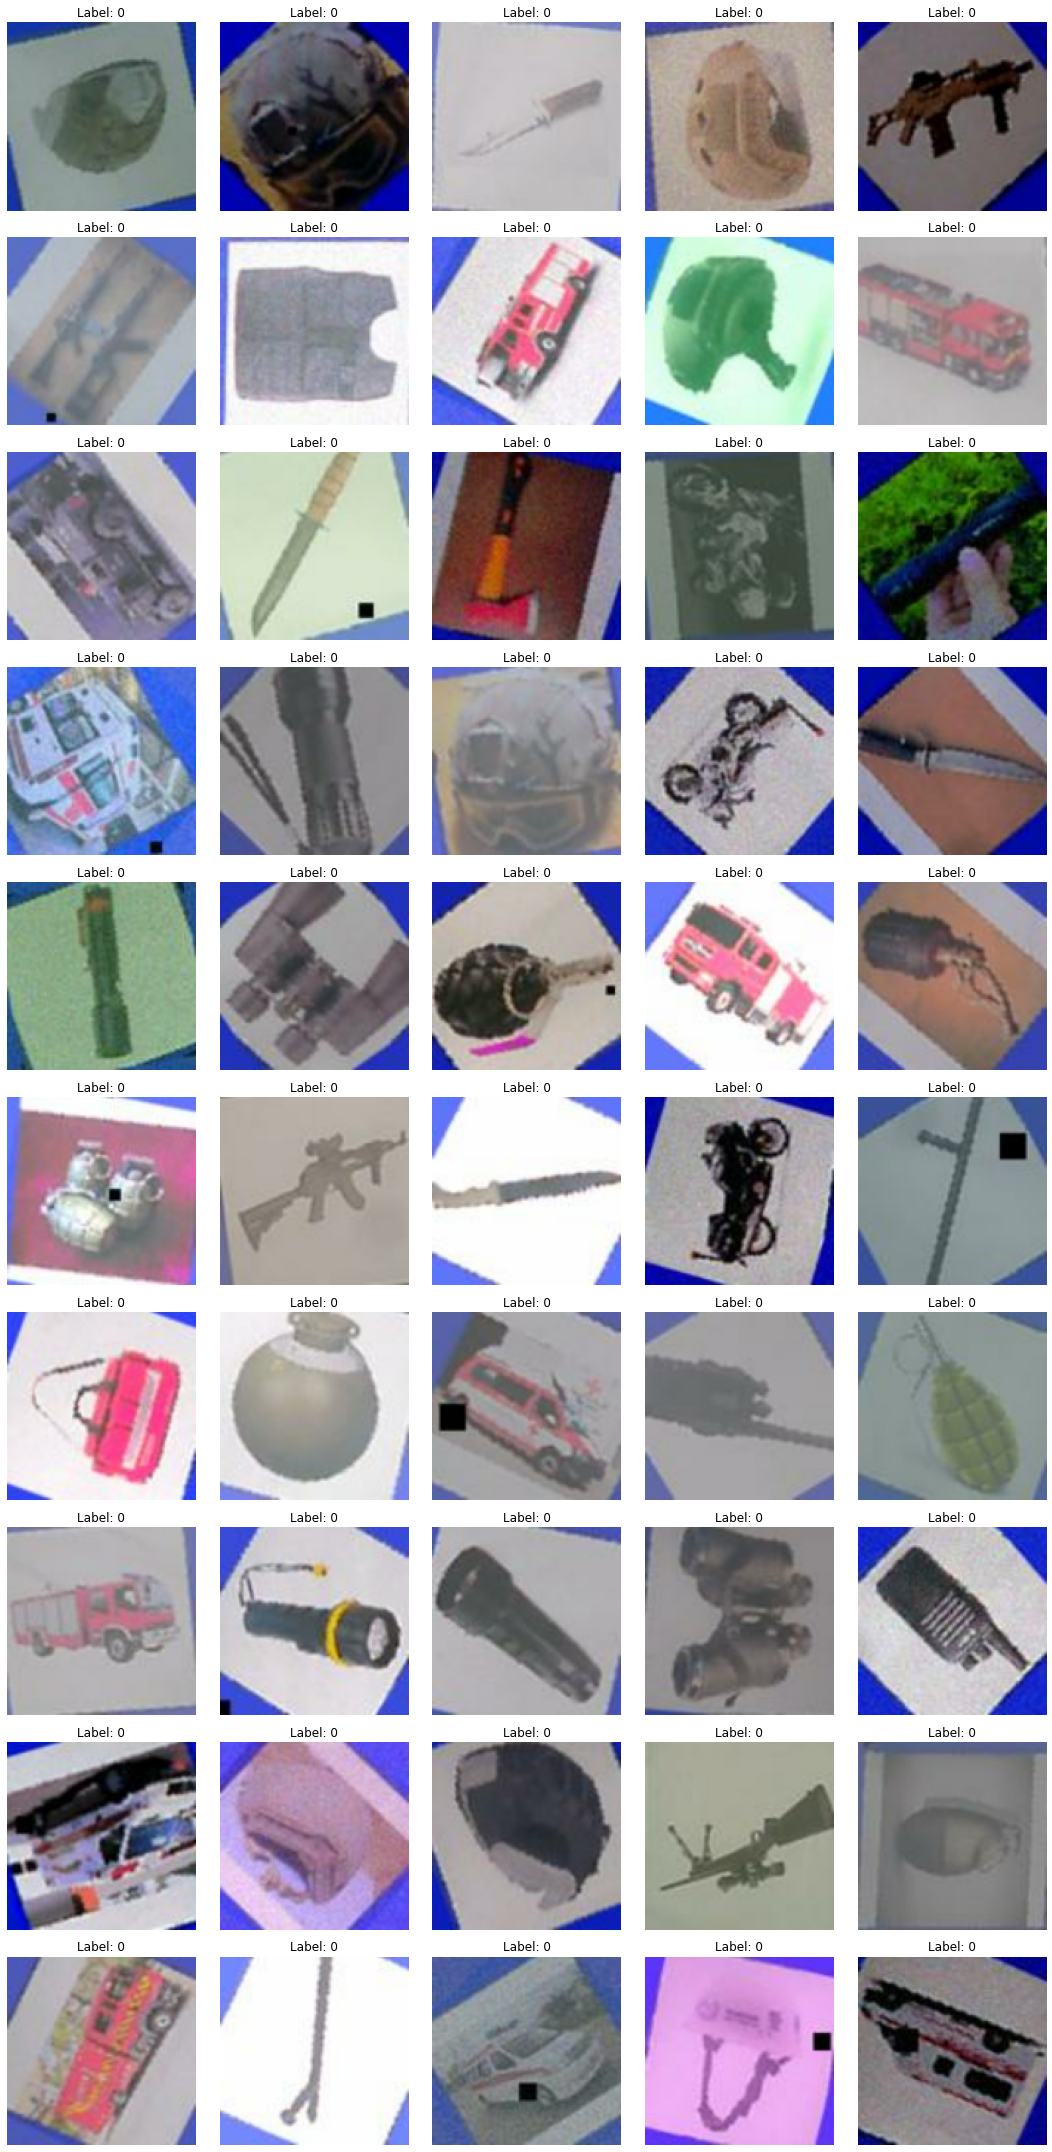

In [18]:
# # 获取一个批次的图像和标签
# images, labels = next(train_dataset)

# images, labels = next(train_dataset)

# # 设置要显示的图像数量和布局
# num_images_to_display = 50  # 总共要显示的图像数量
# images_per_row = 5          # 每行显示的图像数量
# rows = (num_images_to_display + images_per_row - 1) // images_per_row  # 计算行数

# plt.figure(figsize=(15, rows * 3))

# for i in range(num_images_to_display):
#     ax = plt.subplot(rows, images_per_row, i + 1)
#     plt.imshow(images[i].astype("uint8"))
#     plt.title(f"Label: {np.argmax(labels[i])}")
#     plt.axis("off")

# plt.tight_layout()
# plt.show()

# 获取一个批次的图像和标签
# 获取一个批次的图像和标签
iterator = iter(train_dataset)
images, labels = next(iterator)

# 设置要显示的图像数量和布局
num_images_to_display = 50  # 总共要显示的图像数量
images_per_row = 5          # 每行显示的图像数量
rows = (num_images_to_display + images_per_row - 1) // images_per_row  # 计算行数

plt.figure(figsize=(15, rows * 3))

for i in range(num_images_to_display):
    ax = plt.subplot(rows, images_per_row, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))  # 使用 .numpy() 将 Tensor 转换为 NumPy 数组
    plt.title(f"Label: {np.argmax(labels[i])}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [19]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=["accuracy"])


## 开始训练
建立三个回调，学习率降低，早停，权重保存。

In [20]:

import time
import os
save_path = './MobileV3/%s' % (time.strftime('%Y_%m_%d_%H_%M_%S'))

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=10,verbose=1)
early_stop =keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10,verbose=1)
save_weights = keras.callbacks.ModelCheckpoint(save_path + "/model_{epoch:02d}_{val_accuracy:.4f}.h5",
                                                   save_best_only=True, monitor='val_accuracy')
hist = model.fit(train_dataset, 
                 epochs=epochs,
                 validation_data=valid_dataset,
                  callbacks=[save_weights,early_stop,reduce_lr]
                 )

Epoch 1/100
345/345 [==============================] - 12s 27ms/step - loss: 0.6785 - accuracy: 0.8069 - val_loss: 0.3213 - val_accuracy: 0.9064 - lr: 1.0000e-04
Epoch 2/100
345/345 [==============================] - 8s 24ms/step - loss: 0.2786 - accuracy: 0.9146 - val_loss: 0.2301 - val_accuracy: 0.9298 - lr: 1.0000e-04
Epoch 3/100
345/345 [==============================] - 8s 24ms/step - loss: 0.2088 - accuracy: 0.9336 - val_loss: 0.1888 - val_accuracy: 0.9415 - lr: 1.0000e-04
Epoch 4/100
345/345 [==============================] - 8s 24ms/step - loss: 0.1693 - accuracy: 0.9471 - val_loss: 0.1713 - val_accuracy: 0.9467 - lr: 1.0000e-04
Epoch 5/100
345/345 [==============================] - 8s 24ms/step - loss: 0.1413 - accuracy: 0.9555 - val_loss: 0.1539 - val_accuracy: 0.9514 - lr: 1.0000e-04
Epoch 6/100
345/345 [==============================] - 8s 24ms/step - loss: 0.1233 - accuracy: 0.9614 - val_loss: 0.1424 - val_accuracy: 0.9550 - lr: 1.0000e-04
Epoch 7/100
345/345 [============

## 可视化

findfont: Font family ['SimHei'] not found. Falling back to DejaVu Sans.
findfont: Font family ['SimHei'] not found. Falling back to DejaVu Sans.


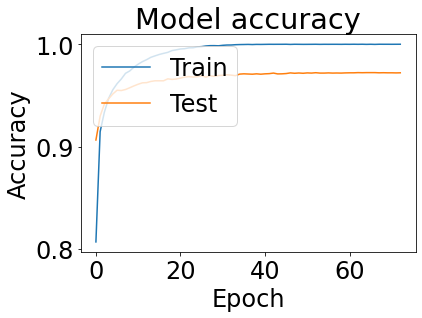

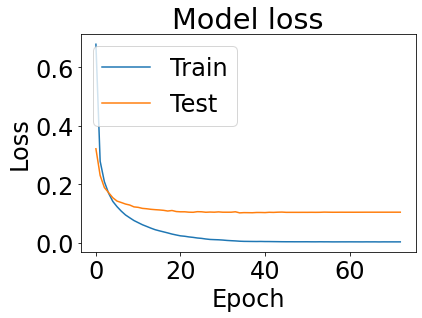

In [25]:
import matplotlib.pyplot as plt
import pandas as pd
plt.figure()
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig(f'{save_path}/acc')

# 绘制训练 & 验证的损失值
plt.figure()
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig(f'{save_path}/loss')

df = pd.DataFrame.from_dict(hist.history)
df.to_csv(f'{save_path}/hist.csv', encoding='utf-8', index=False)

## 绘制混淆矩阵

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib
font = {'family': 'SimHei', "size": 24}
matplotlib.rc('font', **font)

def get_confusion_matrix(label,y_pred,cls):
    Confusion_Matrix = confusion_matrix(label, y_pred)
    cls_sum = Confusion_Matrix.sum(axis=0)
    Confusion_Matrix = Confusion_Matrix/cls_sum#归一化
    print(np.around(Confusion_Matrix,3))
    Confusion_Matrix=Confusion_Matrix*255
    plt.matshow(Confusion_Matrix, cmap=plt.cm.Greens)
    plt.xlabel('predict')
    plt.ylabel('true')
    xlocations = np.array(range(len(cls)))
    print(cls)
    print(xlocations)
    plt.xticks(xlocations, cls, rotation=0)
    plt.yticks(xlocations, cls)
    plt.show()

# 量化

## 测试

In [27]:
import tensorflow as tf
from tqdm import tqdm
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
def tflite_pre(modelpath,dataset_root,batch_size=128,input_size = 128):
    test_root = dataset_root

    valid_generator = ImageDataGenerator()
    valid_dataset = valid_generator.flow_from_directory(batch_size=batch_size,
                                                        directory=test_root,
                                                        shuffle=True,
                                                        target_size=(input_size, input_size))
    interpreter = tf.lite.Interpreter(model_path=modelpath)

    input_index = interpreter.get_input_details()
    output_index = interpreter.get_output_details()

    acc=0
    sum=0
    labels=np.array([])
    predictions=np.array([])
    with tqdm(valid_dataset,desc='test_tflite') as d:
        for batch_number, (img, label) in enumerate(d):
            batch = len(label)
            label = label.argmax(axis=1)
            sum += batch
            interpreter.resize_tensor_input(input_index[0]['index'], (batch, input_size, input_size, 3))
            interpreter.resize_tensor_input(output_index[0]['index'], (batch, 15))
            interpreter.allocate_tensors()
            interpreter.set_tensor(input_index[0]['index'], np.array(img, dtype=np.int8))
            interpreter.invoke()
            output = interpreter.get_tensor(output_index[0]['index'])
            output = output.argmax(axis=1)
            correct_pre = np.where(output == label, 1, 0)
            acc += correct_pre.sum()

            predictions =np.append(predictions,output)
            labels=np.append(labels,label)

            if sum >= len(valid_dataset) * batch_size:
                break
            d.set_postfix(acc = acc/sum)
            d.update()
    print("小类准确率：", acc / sum)
    get_confusion_matrix(labels,predictions,valid_dataset.class_indices)
    return acc/sum

## 量化

In [28]:
from tensorflow.keras.models import load_model
import json
import time
import os
def convert_to_tf_lite(model_path,valid_input_size,valid_path=None, convert_data_path = None):
#     model = load_model(model_path)

#     converter = tf.lite.TFLiteConverter.from_keras_model(model)
#     converter.post_training_quantize=True
#     tflite_model = converter.convert()
#     model = tf.keras.models.load_model(model_path)
#     converter = tf.lite.TFLiteConverter.from_keras_model(model)

#     # 开启动态量化
#     converter.optimizations = [tf.lite.Optimize.DEFAULT]
#     tflite_model = converter.convert()
    train_ds : tf.data.Dataset = tf.keras.utils.image_dataset_from_directory(
        convert_data_path,
        shuffle = True,
        image_size=(valid_input_size, valid_input_size),
        subset = "validation",
        seed = 123,
        validation_split = 0.2,
    )
    # def representative_dataset():
    #   for data in tf.data.Dataset.from_tensor_slices((images)).batch(1).take(100):
    #     yield [tf.dtypes.cast(data, tf.float32)]
    def representative_data_gen():
        for batch in train_ds.take(500):
            for image in batch[0]:
                # 确认输入形状
                # print(f"Original image shape: {image.shape}")
                reshaped_image = tf.reshape(image, (1, valid_input_size, valid_input_size, 3))
                # print(f"Reshaped image shape: {reshaped_image.shape}")
                yield [reshaped_image]
    model = tf.keras.models.load_model(model_path)
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.representative_dataset = representative_data_gen
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8] # TFLITE_BUILTINS_INT8
    converter.inference_input_type = tf.int8
    converter.inference_output_type = tf.int8
    tflite_model = converter.convert()
    start_time = time.strftime('%m_%d_%H_%M')
    name = model_path.split('/')[-1][:-3]

    save_root = "./tflite_model/%s_" % start_time +'_' + name
    os.mkdir(save_root)

    save_path = save_root+"/"+str(valid_input_size)+name+'.tflite'

    with open(save_path, 'wb') as f:
        f.write(tflite_model)
    if valid_path!=None:
        acc = tflite_pre(modelpath=save_path,
                         dataset_root=valid_path,
                         input_size=valid_input_size)
        remark = {'model_path':model_path,'input_size':valid_input_size,'valid_path':valid_path,'acc':acc}
        with open(save_root+"/remark.json",'w',encoding='utf-8') as f:
            json.dump(remark,f)

In [29]:
convert_to_tf_lite(model_path='/root/autodl-tmp/17-ai-train-main/MobileV3/2024_08_10_23_14_47/model_63_0.9723.h5',
                   valid_input_size=input_size,
                   valid_path="/root/autodl-tmp/test_openart",
                   convert_data_path = "/root/autodl-tmp/openartImage")

Found 55154 files belonging to 15 classes.
Using 11030 files for validation.


INFO:tensorflow:Assets written to: /tmp/tmpni3sig69/assets


INFO:tensorflow:Assets written to: /tmp/tmpni3sig69/assets
/root/miniconda3/lib/python3.8/site-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2024-08-10 23:27:25.737706: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2024-08-10 23:27:25.737744: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2024-08-10 23:27:25.738793: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmpni3sig69
2024-08-10 23:27:25.802107: I tensorflow/cc/saved_model/reader.cc:81] Reading meta graph with tags { serve }
2024-08-10 23:27:25.802130: I tensorflow/cc/saved_model/reader.cc:122] Reading SavedModel debug info (if present) from: /tmp/tmpni3sig69
2024-08-10 23:27:25.938528: I tensorflow/compiler/mlir/mlir_graph_opt

Found 27645 images belonging to 15 classes.


test_tflite:  46%|████▌     | 99/216 [02:39<03:08,  1.61s/it, acc=0.198] 

KeyboardInterrupt



In [8]:
new_model = tf.keras.models.load_model('/root/autodl-tmp/17-ai-train-main/2024_8_9_save2/2024_08_10_00_14_22/model_34_0.9973.h5')

# Show the model architecture
new_model.summary()
new_model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=["accuracy"])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 128, 128, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 128, 128, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_0.35_128 (Funct  (None, 4, 4, 1280)       410208    
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                  

In [9]:
import time
import os
save_path = './2024_8_9_save2/%s' % (time.strftime('%Y_%m_%d_%H_%M_%S'))

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=10,verbose=1)
early_stop =keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10,verbose=1)
save_weights = keras.callbacks.ModelCheckpoint(save_path + "/model_{epoch:02d}_{val_accuracy:.4f}.h5",
                                                   save_best_only=True, monitor='val_accuracy')
hist = new_model.fit(train_dataset, 
                 epochs=epochs,
                 validation_data=valid_dataset,
                  callbacks=[save_weights,early_stop,reduce_lr]
                 )


Epoch 1/100


2024-08-10 22:24:56.450521: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2024-08-10 22:24:57.867935: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


173/173 [==============================] - 20s 85ms/step - loss: 0.0417 - accuracy: 0.9901 - val_loss: 1.8300e-04 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 2/100
173/173 [==============================] - 13s 77ms/step - loss: 2.4345e-04 - accuracy: 1.0000 - val_loss: 5.1429e-05 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 3/100
173/173 [==============================] - 13s 77ms/step - loss: 1.0616e-04 - accuracy: 1.0000 - val_loss: 2.6290e-05 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 4/100
173/173 [==============================] - 13s 77ms/step - loss: 6.3747e-05 - accuracy: 1.0000 - val_loss: 1.5829e-05 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 5/100
173/173 [==============================] - 13s 77ms/step - loss: 4.5880e-05 - accuracy: 1.0000 - val_loss: 1.0582e-05 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 6/100
173/173 [==============================] - 13s 77ms/step - loss: 3.0794e-05 - accuracy: 1.0000 - val_loss: 7.3092e-06 - val_accuracy: 1.0000 - lr: 1.0000e

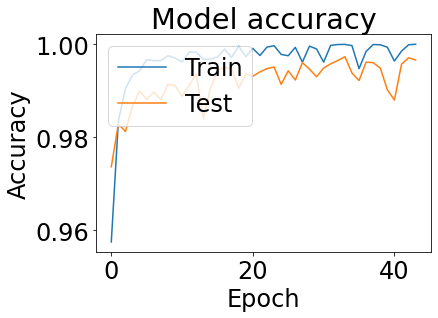

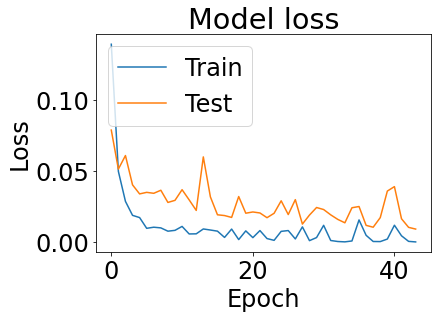

In [54]:
import matplotlib.pyplot as plt
import pandas as pd
plt.figure()
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig(f'{save_path}/acc')

# 绘制训练 & 验证的损失值
plt.figure()
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig(f'{save_path}/loss')

df = pd.DataFrame.from_dict(hist.history)
df.to_csv(f'{save_path}/hist.csv', encoding='utf-8', index=False)

# 超参搜索

## 简单例子
先来个简单的例子

### 定义超模型

In [1]:
from tensorflow import keras
import keras_tuner

class HyperModel(keras_tuner.HyperModel):
    def model(self,units,num_layers,lr):
        model = keras.Sequential()
        model.add(keras.layers.Rescaling(scale=1 / 127.5, offset=-1))
        model.add(keras.layers.Flatten())
        for i in range(num_layers):
            model.add(keras.layers.Dense(units, activation='relu'))
        model.add(keras.layers.Dropout(rate=0.3))
        model.add(keras.layers.Dense(10, activation="softmax"))
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=lr),
            loss="categorical_crossentropy",
            metrics=["accuracy"],
        )
        return model
    def build(self, hp):

        units = hp.Int("units", min_value=64, max_value=256, step=32)
        num_layers = hp.Int("num_layers",min_value=1,max_value=3)
        lr = hp.Float("lr",min_value=1e-5,max_value=1e-3,sampling="log")

        return self.model(units,num_layers,lr) 
    def fit(self, hp, model, x_train,y_train, **kwargs):
        return model.fit(
            x_train,
            y_train,
            **kwargs
        )

### 利用mnist测试

In [2]:
from tensorflow import keras
import numpy as np

(x, y), (x_test, y_test) = keras.datasets.mnist.load_data()

x = np.expand_dims(x,axis=-1)
x_test = np.expand_dims(x_test,axis=-1)

num_classes =10
y = keras.utils.to_categorical(y, num_classes)
y_test = keras.utils.to_categorical(y_test,num_classes)


In [33]:
tuner = keras_tuner.RandomSearch(
    HyperModel(),
    objective="val_accuracy",
    max_trials=10,
    overwrite=True,
    directory="my_dir",
    project_name="tune_hypermodel",
)

In [34]:
tuner.search(x,y,epochs=2,batch_size=128,validation_data=(x_test, y_test),workers =8)

Trial 10 Complete [00h 00m 04s]
val_accuracy: 0.9144999980926514

Best val_accuracy So Far: 0.9641000032424927
Total elapsed time: 00h 00m 38s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()


In [ ]:
hypermodel = HyperModel()
best_hp = tuner.get_best_hyperparameters()[0]
model = hypermodel.build(best_hp)
hypermodel.fit(best_hp, model, x, y, epochs=20,batch_size=128,validation_data=(x_test, y_test),workers =8)

In [37]:
model.save('demo_hypermodel.h5')

In [38]:
from tensorflow.keras.models import load_model
model = load_model('demo_hypermodel.h5')
model.evaluate(
    x_test,
    y_test,
    batch_size=128,
)

79/79 [==============================] - 0s 4ms/step - loss: 0.0770 - accuracy: 0.9808


[0.07700708508491516, 0.9807999730110168]

## 超·MobileNetV2
正式开始

In [3]:
def Mobilenet_v2(input_size,weights,Dropout_rate,Trainable,alpha = 0.35):
    base_model = keras.applications.MobileNetV2(
        input_shape=(input_size, input_size, 3),
        alpha=alpha,
        weights=weights,
        include_top=False
    )
    inputs = keras.Input(shape=(input_size, input_size,3))

    scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
    x = scale_layer(inputs)
    x = base_model(x, training=False)
    if Trainable:
        base_model.trainable =True
    else:
        base_model.trainable = False
        print("特征层已冻结")
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dropout(Dropout_rate, name='Dropout')(x)
    outputs = keras.layers.Dense(15, activation='softmax')(x)
    model = keras.Model(inputs, outputs)
    return model

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
class HyperMobilenet_v2(keras_tuner.HyperModel):
    def __init__(self,input_size,batch_size,train_root):
        super(keras_tuner.HyperModel, self).__init__()
        self.input_size = input_size
        self.batch_size = batch_size
        self.train_root = train_root
    def model(self,Dropout_rate,lr):
        model = Mobilenet_v2(
            input_size=self.input_size,
            weights='imagenet',
            Dropout_rate=Dropout_rate,
            Trainable=True
        )
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
                    loss=keras.losses.CategoricalCrossentropy(),
                    metrics=["accuracy"])
        return model
    def build(self, hp):
        lr = hp.Float("lr",min_value=1e-5,max_value=1e-3,sampling="log")
        Dropout_rate = hp.Choice("Dropout_rate",values =[0.1,0.2,0.3,0.4,0.5,0.6])
        return self.model(Dropout_rate,lr) 
    
    def dataset(self, hp):

        train_root = self.train_root

        zoom_range = hp.Float("zoom_range",min_value=0.1,max_value=0.3,sampling="linear")
        channel_shift_range = hp.Int("channel_shift_range",min_value=0,max_value=30,step=10)

        train_generator = ImageDataGenerator(rotation_range=360,
                                            zoom_range =zoom_range,
                                            horizontal_flip = True,
                                            validation_split =0.2,
                                            channel_shift_range =channel_shift_range
                                            )
        train_dataset = train_generator.flow_from_directory(batch_size=self.batch_size,
                                                            directory=train_root,
                                                            shuffle=True,
                                                            target_size=(self.input_size,self.input_size),
                                                            subset='training')
        valid_dataset = train_generator.flow_from_directory(batch_size=self.batch_size,
                                                            directory=train_root,
                                                            shuffle=True,
                                                            target_size=(self.input_size,self.input_size),
                                                            subset='validation')
        return train_dataset,valid_dataset

    def fit(self, hp, model,**kwargs):
        
        train_dataset,valid_dataset = self.dataset(hp)

        return model.fit(
            train_dataset,
            validation_data=valid_dataset,
            **kwargs
        ) 

In [6]:
tuner = keras_tuner.BayesianOptimization(
    hypermodel =HyperMobilenet_v2(input_size=128,batch_size=128,train_root='./train/'),
    objective="val_accuracy",
    max_trials=50,
    overwrite=True,
    directory="my_dir",
    project_name="tune_hypermodel",
)
tuner.search(epochs=10,workers=8)

Trial 50 Complete [00h 00m 24s]
val_accuracy: 0.8133047223091125

Best val_accuracy So Far: 0.8476395010948181
Total elapsed time: 00h 23m 59s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

In [20]:
hypermodel = HyperMobilenet_v2(input_size=128,batch_size=128,train_root='./train/')
best_hp = tuner.get_best_hyperparameters()[0]
model = hypermodel.build(best_hp)

In [ ]:
import time
import os
save_path = './models_save/%s' % (time.strftime('%Y_%m_%d_%H_%M_%S'))
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=10,verbose=1)
early_stop =keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15,verbose=1)
save_weights = keras.callbacks.ModelCheckpoint(save_path + "/model_{epoch:02d}_{val_accuracy:.4f}.h5",
                                                   save_best_only=True, monitor='val_accuracy')

hypermodel.fit(
    best_hp, 
    model,
    epochs=100,
    workers =8,
    callbacks=[save_weights,early_stop,reduce_lr]
    )